In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os

# Import geomap of the Netherlands
mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
mapdf = mapdf[mapdf["H2O"] == "NEE"]
mapdf.sort_values("GM_NAAM", inplace=True)
mapdf = mapdf.reset_index(drop=True)
print(mapdf.columns)

# Compute distances between all municipalities
mapdf['GEO_CENTROID'] = mapdf.centroid
centres = mapdf['GEO_CENTROID']
n_mun = mapdf.shape[0]

# dist_matrix = np.zeros(shape=(n_mun, n_mun))
# for i in range(0, n_mun):
#     dist_matrix[i] = centres.distance(centres[i])

# Compute mobility based gravity model, without distances
population = mapdf['AANT_INW']
mob_matrix = np.zeros(shape=(n_mun, n_mun))
for i in range(0, n_mun):
    for j in range(0, n_mun):
        if i != j:
            mob_matrix[i,j] = population[i] * population[j]

# Import original data to normalize to
df_mobmat_freq = pd.read_csv('Data/Mob_grav_freq.csv', delimiter=',')
mobmat_freq = df_mobmat_freq[df_mobmat_freq.columns[1:]].to_numpy()

df_mobmat_inc = pd.read_csv('Data/Mob_grav_inc.csv', delimiter=',')
mobmat_inc = df_mobmat_inc[df_mobmat_inc.columns[1:]].to_numpy()

# Normalize row sums to original data, so total amount traveled per municipality is the same.
mob_matrix_freq = np.zeros(shape=(n_mun, n_mun))
mob_matrix_inc = np.zeros(shape=(n_mun, n_mun))
for i in range(n_mun):
    diff_freq = np.nansum(mob_matrix[i]) / np.nansum(mobmat_freq[i])
    mob_matrix_freq[i] = mob_matrix[i] / diff_freq

    diff_inc  = np.nansum(mob_matrix[i]) / np.nansum(mobmat_inc[i])
    mob_matrix_inc[i] = mob_matrix[i] / diff_inc

# Save the new matrix
path = os.getcwd() + '/Data/'
np.save(path + 'Randomized_mob_grav_freq', mob_matrix_freq)
np.save(path + 'Randomized_mob_grav_inc', mob_matrix_inc)

In [41]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib
import pandas as pd
import numpy as np
import os

ppl_per_agent = 100

path_gem_names = os.getcwd() + '/Data/Gem_alfabetisch_2018.csv'

DF_Gem = pd.read_csv(path_gem_names, delimiter=';', encoding='latin-1')
UniLocs = np.unique(DF_Gem.Gemeentenaam)
UniIDs = [list(DF_Gem.GemeentecodeGM[DF_Gem.Gemeentenaam == i])[0] for i in UniLocs]

path_demo = os.getcwd() + '/Data/DemographicMatrix.csv'

DF_Demo = pd.read_csv(path_demo, delimiter=',')
DemoIDs = np.array(DF_Demo['Unnamed: 0'])
DemoMat_unsorted = np.array(DF_Demo[DF_Demo.keys()[1:]])
DemoMat_sorted = []
for ID in UniIDs:
    DemoMat_sorted.append(DemoMat_unsorted[DemoIDs == int(ID.lstrip('GM'))])
DemoMat = (np.array(DemoMat_sorted)/ppl_per_agent).astype(int)[:, 0]

DemoFractionsMat = np.zeros(shape=DemoMat.shape)
for i in range(0, DemoMat.shape[0]):
    DemoFractionsMat[i] = DemoMat[i] / np.sum(DemoMat[i])



# Useful functions
def create_spatial_plot(data_per_municipality, title, legend_label):
    '''
    Plot map with data per municipality
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_val = np.max(data_per_municipality)

    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    fig.suptitle(title)
    ax.axis('off')

    mapdf.insert(0, 'DATA', data_per_municipality)

    mapdf.plot(ax=ax, column="DATA", 
               legend=True, legend_kwds={"label": legend_label, "orientation": "vertical"})

    plt.plot()



def create_spatial_4plots(data_per_municipality, title, legend_label):
    '''
    Plot 4 maps, evenly spread out over time
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_time = data_per_municipality.shape[0]
    max_val = np.max(data_per_municipality[max_time-1])

    fig, axs = plt.subplots(1, 4, figsize=(20, 8))
    fig.suptitle(title)

    mapdf.insert(0, 'DATA_QUARTER', data_per_municipality[int(max_time/4)])
    mapdf.insert(0, 'DATA_HALF', data_per_municipality[int(max_time/2)])
    mapdf.insert(0, 'DATA_3QUARTER', data_per_municipality[int(max_time*3/4)])
    mapdf.insert(0, 'DATA_MAXTIME', data_per_municipality[max_time-1])

    mapdf.plot(ax=axs[0], column="DATA_QUARTER", norm=matplotlib.colors.LogNorm(1,max_val))
    mapdf.plot(ax=axs[1], column="DATA_HALF", norm=matplotlib.colors.LogNorm(1,max_val))
    mapdf.plot(ax=axs[2], column="DATA_3QUARTER", norm=matplotlib.colors.LogNorm(1,max_val))
    mapdf.plot(ax=axs[3], column="DATA_MAXTIME", norm=matplotlib.colors.LogNorm(1,max_val))


    axs[0].set_title('t=' + str(int(max_time/4)))
    axs[1].set_title('t=' + str(int(max_time/2)))
    axs[2].set_title('t=' + str(int(max_time*3/4)))
    axs[3].set_title('t=' + str(int(max_time-1)))

    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')
    axs[3].axis('off')

    mappable = cm.ScalarMappable(
        norm=mcolors.Normalize(1, max_val))

    cb_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

    cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal')
    cbar.set_label(legend_label)

    plt.tight_layout()
    plt.plot()


# DAILY PLOT FOR 1 WEEK

def create_spatial_7plots(data_per_municipality, max_legend_val, title, legend_label, print_foi_sums=False):
    '''
    Plot a daily map for 1 week
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_time = data_per_municipality.shape[0]
    if max_legend_val == None:
        max_legend_val = np.max(data_per_municipality[max_time-1])

    fig, axs = plt.subplots(1, 7, figsize=(21, 5))
    fig.suptitle(title)

    for day in range(0, 7):
        day_num = day + 1
        mapdf.insert(0, 'DAY_' + str(day_num), data_per_municipality[day_num * 24 - 1])
        if print_foi_sums:
            print('Day ' + str(day_num) + ': ' + str(np.sum(data_per_municipality[day_num * 24 - 1])))
        mapdf.plot(ax=axs[day], column='DAY_' + str(day_num), norm=matplotlib.colors.LogNorm(1, max_legend_val))
        axs[day].set_title('Day ' + str(day_num))
        axs[day].axis('off')

    mappable = cm.ScalarMappable(
        norm=matplotlib.colors.LogNorm(1, max_legend_val))

    cb_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

    cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal')
    cbar.set_label(legend_label)

    plt.tight_layout()
    plt.plot()


def create_spatial_7plots3(data_per_municipality, max_legend_val, title, legend_label, print_foi_sums=False):
    '''
    Plot 7 maps, spaced 3 days apart
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_time = data_per_municipality.shape[0]
    if max_legend_val == None:
        max_legend_val = np.max(data_per_municipality[max_time-1])

    fig, axs = plt.subplots(1, 7, figsize=(21, 5))
    fig.suptitle(title)

    for day in range(0, 7):
        day_num = (day + 1) * 3
        mapdf.insert(0, 'DAY_' + str(day_num), data_per_municipality[day_num * 24 - 1])
        if print_foi_sums:
            print('Day ' + str(day_num) + ': ' + str(np.sum(data_per_municipality[day_num * 24 - 1])))
        mapdf.plot(ax=axs[day], column='DAY_' + str(day_num), norm=matplotlib.colors.LogNorm(1, max_legend_val))
        axs[day].set_title('Day ' + str(day_num))
        axs[day].axis('off')

    mappable = cm.ScalarMappable(
        norm=matplotlib.colors.LogNorm(1, max_legend_val))

    cb_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

    cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal')
    cbar.set_label(legend_label)

    plt.tight_layout()
    plt.plot()


def create_spatial_7plots3_linear(data_per_municipality, max_legend_val, title, legend_label, print_foi_sums=False):
    '''
    Plot 7 maps, spaced 3 days apart
    '''
    mapdf = gpd.read_file('Data/NL-geomap/gemeente_2018_v3.shp')
    mapdf = mapdf[mapdf["H2O"] == "NEE"]
    mapdf.sort_values("GM_NAAM", inplace=True)
    mapdf = mapdf.reset_index(drop=True)

    max_time = data_per_municipality.shape[0]
    if max_legend_val == None:
        max_legend_val = np.max(data_per_municipality[max_time-1])
    min_legend_val = np.min(data_per_municipality[max_time-1])

    print(max_legend_val)

    fig, axs = plt.subplots(1, 7, figsize=(21, 5))
    fig.suptitle(title)

    for day in range(0, 7):
        day_num = (day + 1) * 3
        mapdf.insert(0, 'DAY_' + str(day_num), data_per_municipality[day_num * 24 - 1])
        if print_foi_sums:
            print('Day ' + str(day_num) + ': ' + str(np.sum(data_per_municipality[day_num * 24 - 1])))
        mapdf.plot(ax=axs[day], column='DAY_' + str(day_num), norm=matplotlib.colors.FuncNorm((lambda x: x, lambda x: x), vmin=min_legend_val, vmax=max_legend_val))
        axs[day].set_title('Day ' + str(day_num))
        axs[day].axis('off')

    mappable = cm.ScalarMappable(
        norm=matplotlib.colors.FuncNorm((lambda x: x, lambda x: x), vmin=min_legend_val, vmax=max_legend_val))

    cb_ax = fig.add_axes([0.1, 0.1, 0.8, 0.02])

    cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal')
    cbar.set_label(legend_label)

    plt.tight_layout()
    plt.plot()

    plt.tight_layout()
    plt.plot()




def combine_runs_avg(all_run_data, padding=0.000001):
    merged_data = np.zeros(shape= all_run_data[0].shape)
    for i in range (0, len(all_run_data)):
        merged_data = merged_data + all_run_data[i]
    merged_data = (merged_data / len(all_run_data)) + padding
    return merged_data

def combine_demos_weighted(municipality_id, demo_run_data, padding=0.000001):
    fracs = DemoFractionsMat[municipality_id]
    merged_data = np.zeros(shape= demo_run_data[0].shape)
    for i in range (0, len(demo_run_data)):
        weighted = fracs[i] * demo_run_data[i]
        merged_data = merged_data + weighted
    merged_data = merged_data + padding
    return merged_data

import pandas as pd
import numpy as np
import os

def load_total_infected_per_municipality(path_data, loc, group, run):
    # Load general model data
    peopleDF = pd.read_pickle(path_data + 'PeopleDF.pkl')
    extraPeopleDF = pd.read_pickle(path_data + 'ExtraPeopleDF.pkl')
    status = np.load(path_data + 'Runs_ref_4.6_100_5_risk' + str(loc) + '_' + str(group) + '/Status_' + str(run) + '.npz')
    uniLocs = np.array(pd.read_pickle(os.path.normpath(path_data + '../../Gemeenten.pkl'))).T[0]
    loc_to_id = {val: i for i, val in enumerate(uniLocs)}
    uniGroups = np.unique(np.array(extraPeopleDF.Group))

    extra_agents = extraPeopleDF.loc[(extraPeopleDF['Home'] == uniLocs[loc]) & (extraPeopleDF['Group'] == uniGroups[group])]
    peopleDF = pd.concat([peopleDF, extra_agents], ignore_index=True)

    # Load model output data
    timesteps = status['indptr'].shape[0] - 1
    data = status['data']
    indptr = status['indptr']
    indices = status['indices']

    # Compute for every timestep how many infected people there are in every municipality
    infected_per_municipality = np.zeros((timesteps, 380))
    for t in range(0, timesteps):
        data_t = data[indptr[t] : indptr[t + 1]]
        agents_status_t = indices[indptr[t] : indptr[t + 1]]

        infected_agents = agents_status_t[(data_t == 2) | (data_t == 3)]
        infected_agents_homes = np.array(peopleDF.loc[infected_agents]['Home'])
        for home in infected_agents_homes:
            infected_per_municipality[t, loc_to_id[home]] += 1

    return infected_per_municipality

def load_total_infected_avg_runs(path_data, loc, group, runs):
    all_data = []
    for run in range(runs):
        all_data.append(load_total_infected_per_municipality(path_data, loc, group, run))
        print("Loaded & computed loc: " +str(loc) + " group: " + str(group) + " run: " + str(run)) 

    # Average the data
    merged_data = np.zeros(all_data[0].shape)
    for run in range(runs):
        merged_data = merged_data + all_data[run]
    merged_data = merged_data / runs
    return merged_data


C:\Users\Larsk\AppData\Local\Temp\ipykernel_5012\4029542277.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\Larsk\AppData\Local\Temp\ipykernel_5012\4029542277.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\Larsk\AppData\Local\Temp\ipykernel_5012\4029542277.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


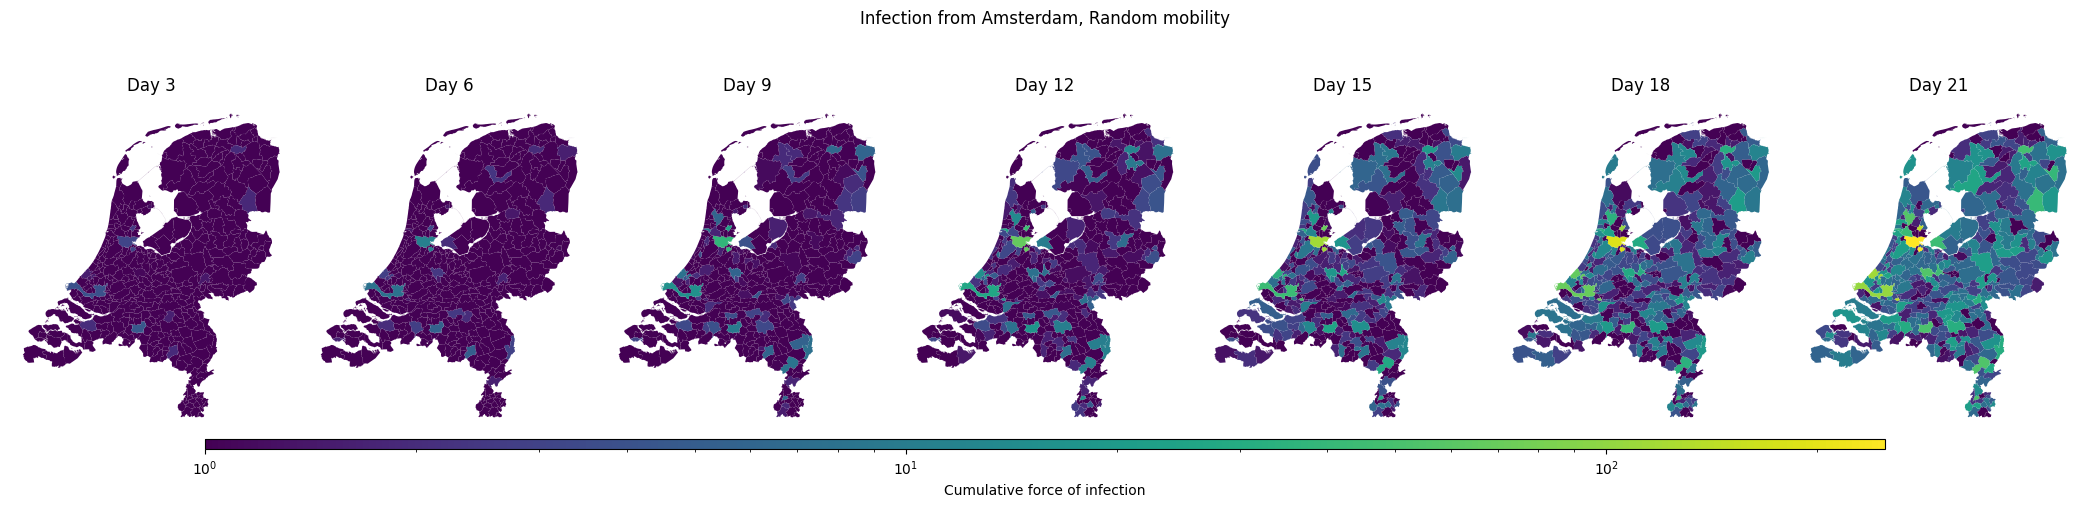

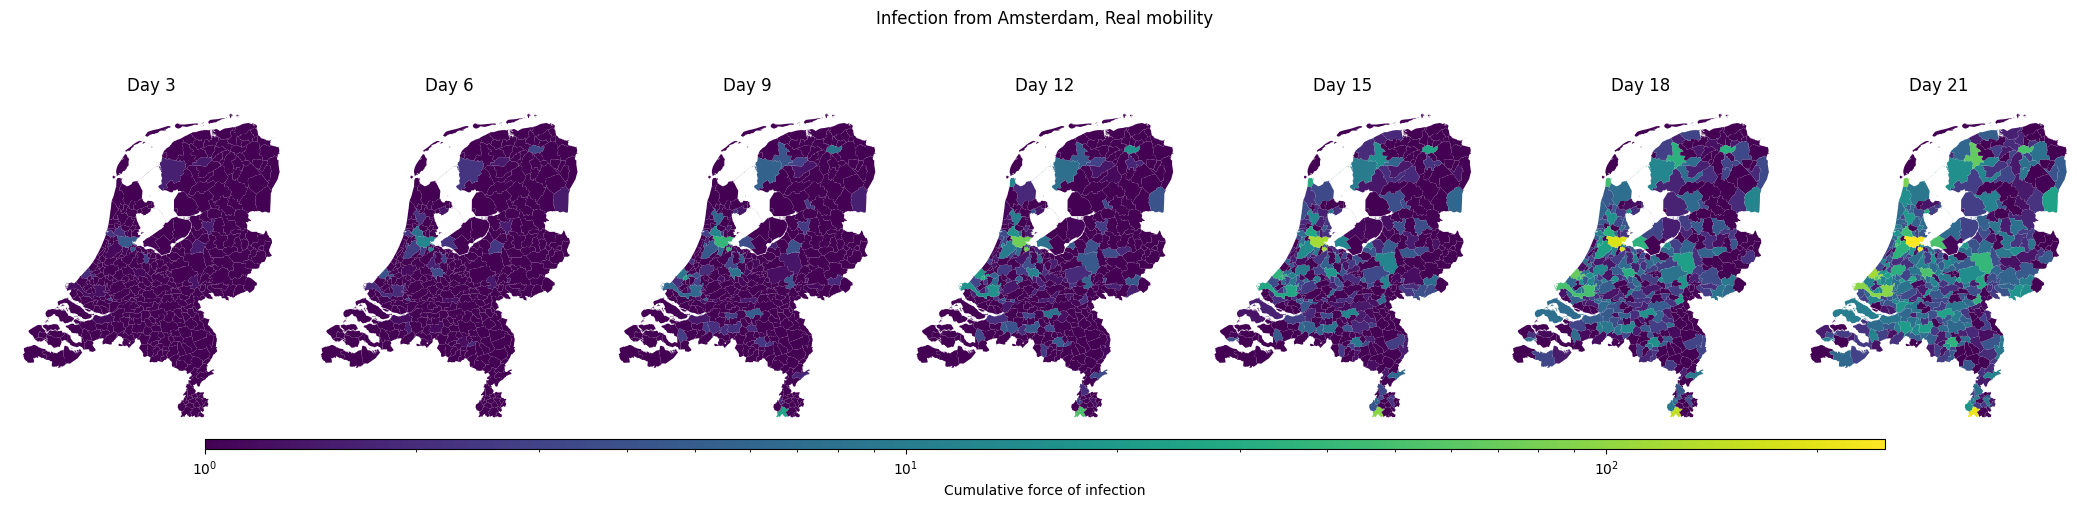

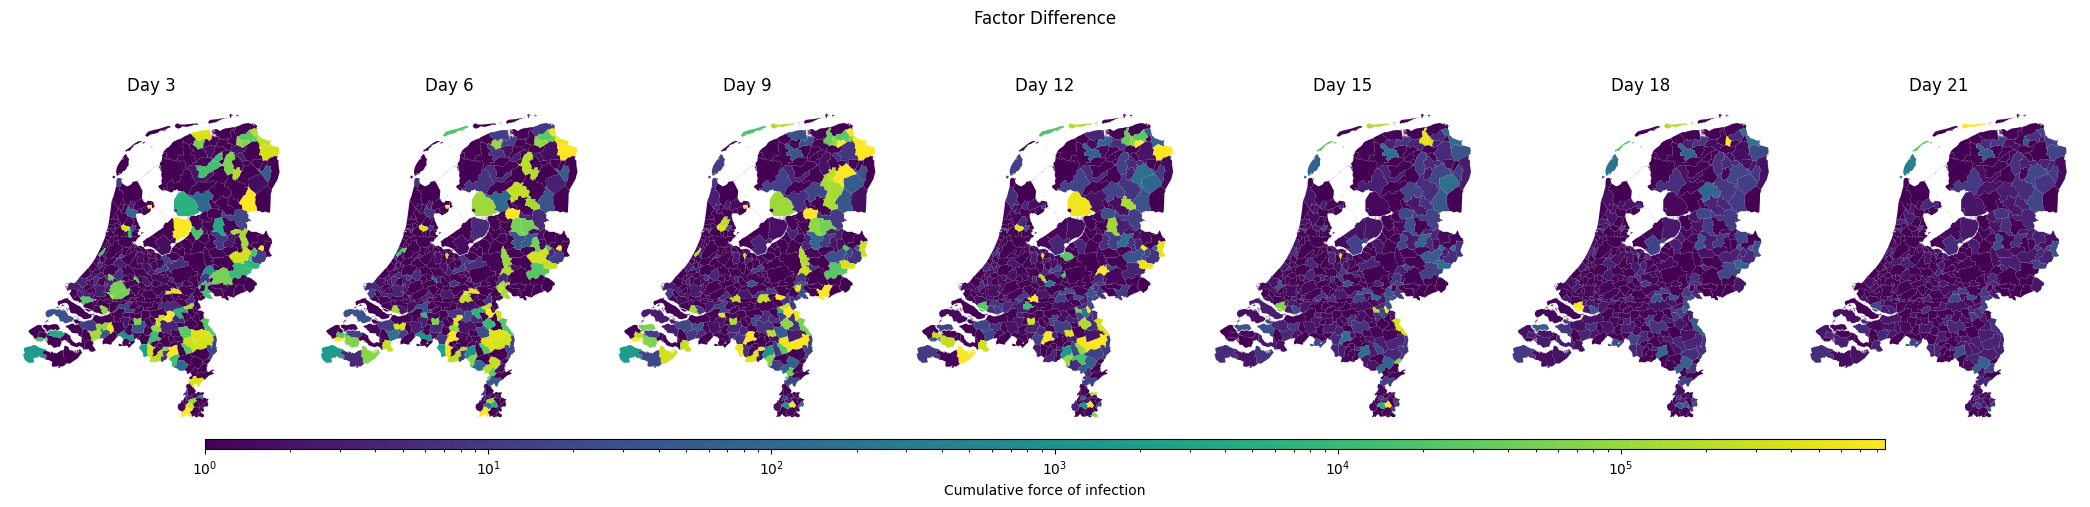

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import os

groundzero = np.where(UniLocs == 'Amsterdam')[0][0]

path_ref = os.getcwd() + '/Data/Model_V1/Data/High/Seed_0/'
path_rnd = os.getcwd() + '/Data/Model_V1/Data/High/Seed_11/'

title = 'Randomized gravity model, Amsterdam, demo group '
all_demo_data_rnd = []
all_demo_data_ref = []
all_demo_data_factor = []
for demo in range(0, 11):
    #avg rnd model runs
    rnd_data = []
    # infected_data_rnd = load_total_infected_avg_runs(path_rnd, 17, demo, 3)
    # all_demo_data_rnd.append(infected_data_rnd)

    for run in range(0, 3):
        foi_data_per_municipality = np.load(path_rnd + '/Runs_ref_4.6_100_5_risk17_' + str(demo) + '/Infection_Pressure_' + str(run) + '.npy')
        rnd_data.append(foi_data_per_municipality)
    avg_rnd_data_per_municipality = combine_runs_avg(rnd_data, 0)
    all_demo_data_rnd.append(avg_rnd_data_per_municipality)

    # avg ref model runs
    ref_data = []
    # infected_data_ref = load_total_infected_avg_runs(path_ref, 17, demo, 3)
    # all_demo_data_ref.append(infected_data_ref)

    for run in range(0, 3):
        foi_data_per_municipality = np.load(path_ref + '/Runs_ref_4.6_100_5_risk17_' + str(demo) + '/Infection_Pressure_' + str(run) + '.npy')
        ref_data.append(foi_data_per_municipality)
    avg_ref_data_per_municipality = combine_runs_avg(ref_data, 0)
    all_demo_data_ref.append(avg_ref_data_per_municipality)

merged_rnd = combine_demos_weighted(groundzero, all_demo_data_rnd)
merged_ref = combine_demos_weighted(groundzero, all_demo_data_ref)

create_spatial_7plots3(merged_rnd, 250, 'Infection from Amsterdam, Random mobility', 'Cumulative force of infection')
create_spatial_7plots3(merged_ref, 250, 'Infection from Amsterdam, Real mobility', 'Cumulative force of infection')

merged_factor = np.divide(merged_rnd, merged_ref, out=np.zeros_like(merged_rnd), where=merged_ref!=0)

create_spatial_7plots3(merged_factor, None, 'Factor Difference', 'Cumulative force of infection')


Loaded & computed loc: 17 group: 0 run: 0
Loaded & computed loc: 17 group: 0 run: 1
Loaded & computed loc: 17 group: 0 run: 2
Loaded & computed loc: 17 group: 0 run: 0
Loaded & computed loc: 17 group: 0 run: 1
Loaded & computed loc: 17 group: 0 run: 2
Loaded & computed loc: 17 group: 1 run: 0
Loaded & computed loc: 17 group: 1 run: 1
Loaded & computed loc: 17 group: 1 run: 2
Loaded & computed loc: 17 group: 1 run: 0
Loaded & computed loc: 17 group: 1 run: 1
Loaded & computed loc: 17 group: 1 run: 2
Loaded & computed loc: 17 group: 2 run: 0
Loaded & computed loc: 17 group: 2 run: 1
Loaded & computed loc: 17 group: 2 run: 2
Loaded & computed loc: 17 group: 2 run: 0
Loaded & computed loc: 17 group: 2 run: 1
Loaded & computed loc: 17 group: 2 run: 2
Loaded & computed loc: 17 group: 3 run: 0
Loaded & computed loc: 17 group: 3 run: 1
Loaded & computed loc: 17 group: 3 run: 2
Loaded & computed loc: 17 group: 3 run: 0
Loaded & computed loc: 17 group: 3 run: 1
Loaded & computed loc: 17 group: 3

C:\Users\Larsk\AppData\Local\Temp\ipykernel_5012\4029542277.py:219: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\Larsk\AppData\Local\Temp\ipykernel_5012\4029542277.py:222: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


14


C:\Users\Larsk\AppData\Local\Temp\ipykernel_5012\4029542277.py:219: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\Larsk\AppData\Local\Temp\ipykernel_5012\4029542277.py:222: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\Larsk\AppData\Local\Temp\ipykernel_5012\4029542277.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


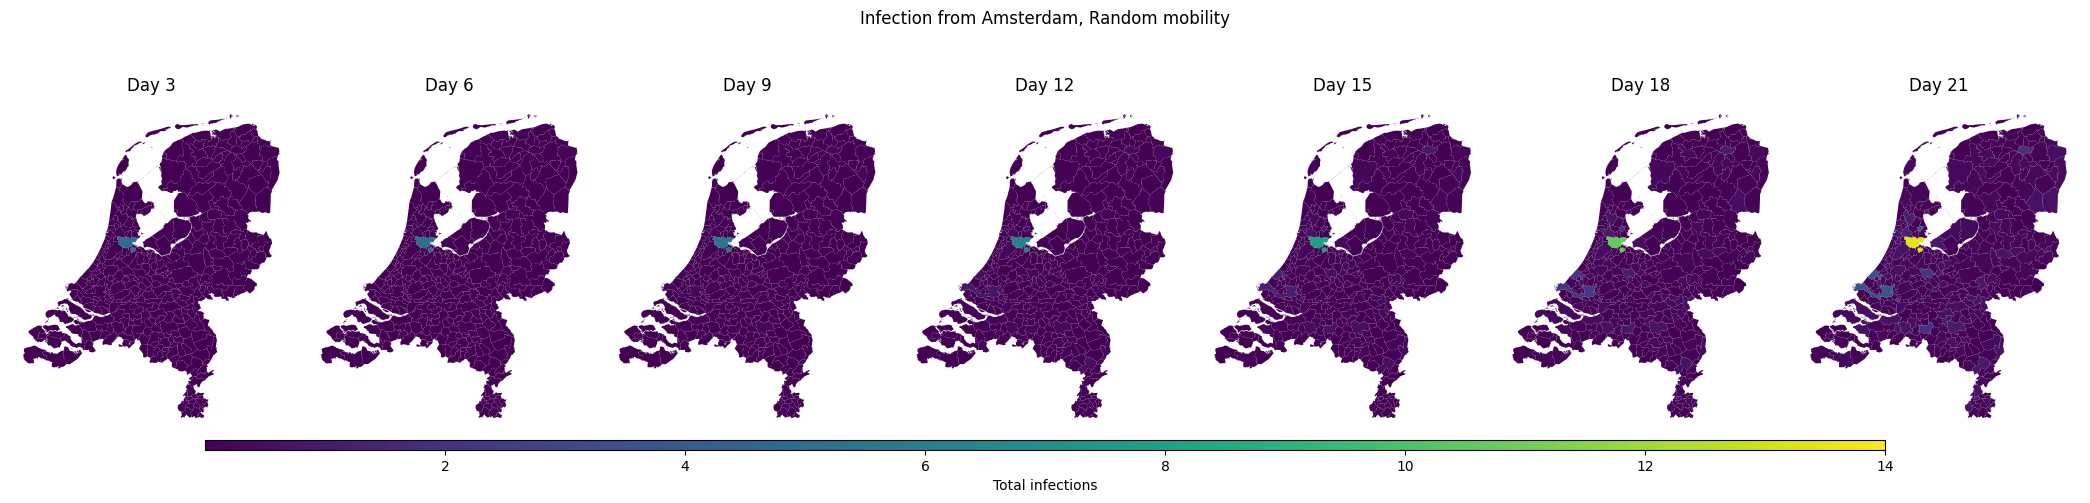

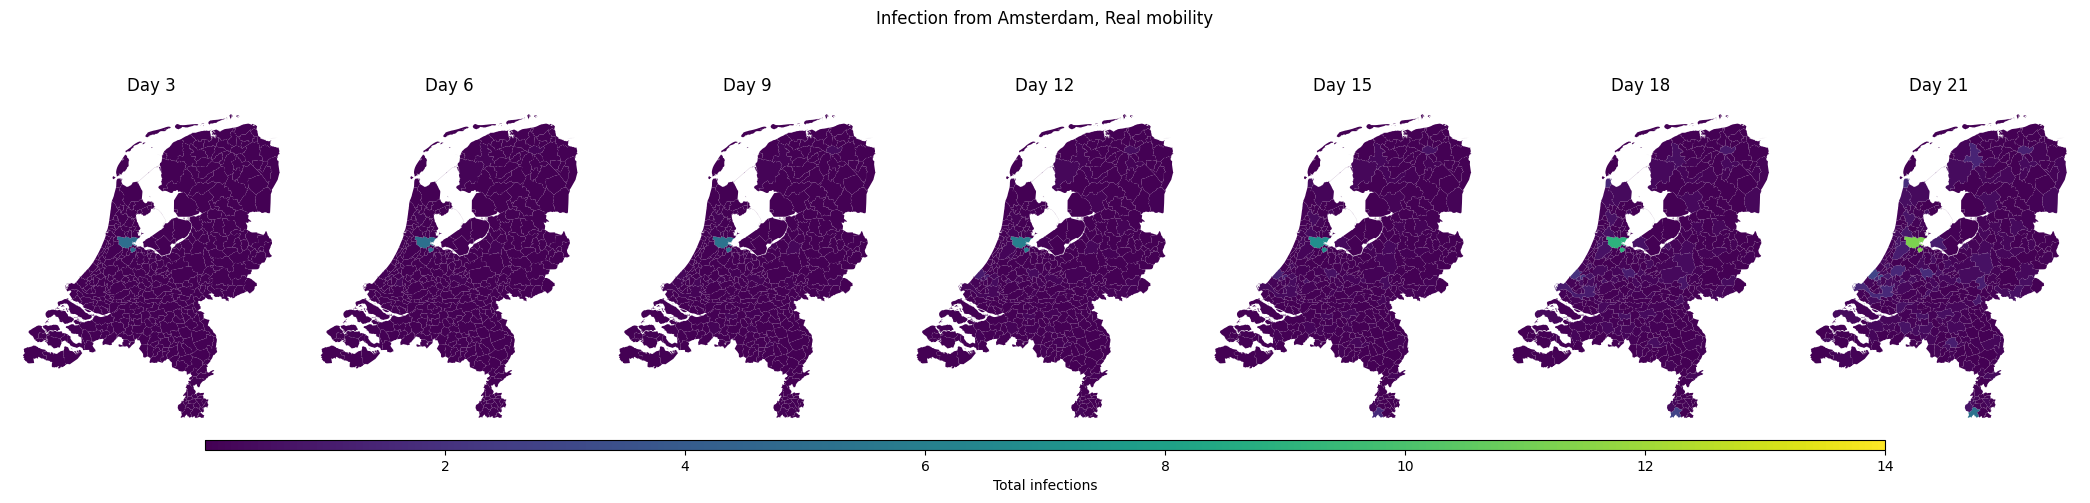

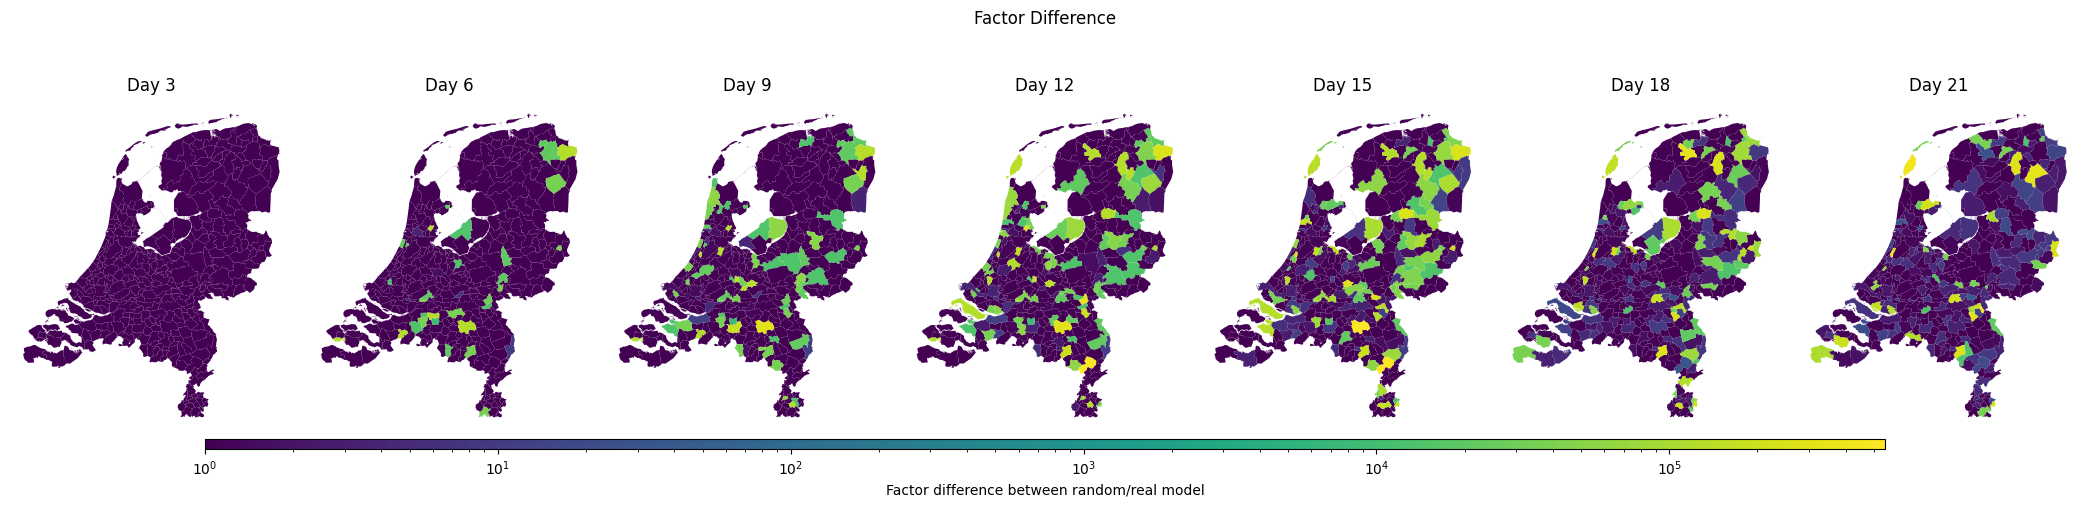

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import os

groundzero = np.where(UniLocs == 'Amsterdam')[0][0]

path_ref = os.getcwd() + '/Data/Model_V1/Data/High/Seed_0/'
path_rnd = os.getcwd() + '/Data/Model_V1/Data/High/Seed_11/'

title = 'Randomized gravity model, Amsterdam, demo group '
all_demo_data_rnd = []
all_demo_data_ref = []
all_demo_data_factor = []
for demo in range(0, 11):
    #avg rnd model runs
    rnd_data = []
    infected_data_rnd = load_total_infected_avg_runs(path_rnd, 17, demo, 3)
    all_demo_data_rnd.append(infected_data_rnd)

    # avg ref model runs
    ref_data = []
    infected_data_ref = load_total_infected_avg_runs(path_ref, 17, demo, 3)
    all_demo_data_ref.append(infected_data_ref)

merged_rnd_infections = combine_demos_weighted(groundzero, all_demo_data_rnd)
merged_ref_infections = combine_demos_weighted(groundzero, all_demo_data_ref)

create_spatial_7plots3_linear(merged_rnd_infections, 14, 'Infection from Amsterdam, Random mobility', 'Total infections')
create_spatial_7plots3_linear(merged_ref_infections, 14, 'Infection from Amsterdam, Real mobility', 'Total infections')

merged_factor_infections = np.divide(merged_rnd_infections, merged_ref_infections, out=np.zeros_like(merged_rnd_infections), where=merged_ref_infections!=0)

create_spatial_7plots3(merged_factor_infections, None, 'Factor Difference', 'Factor difference between random/real model')


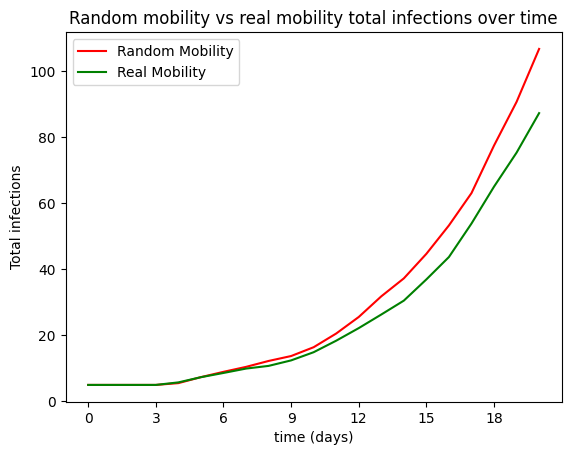

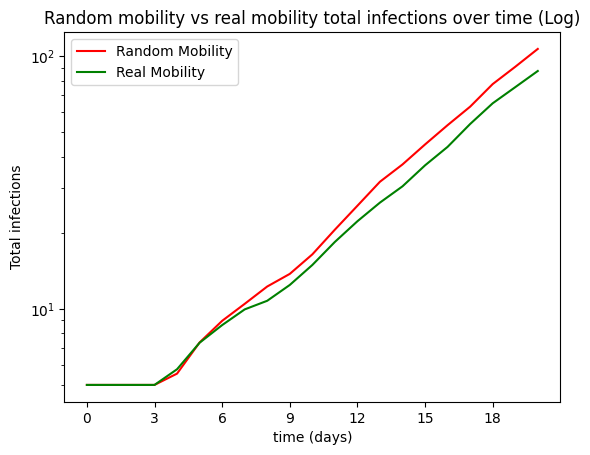

In [97]:
# Plot total force of infection as function of time

t_max = merged_rnd.shape[0]

total_foi_rnd = np.zeros(t_max)
total_foi_ref = np.zeros(t_max)
for i in range(t_max):
    total_foi_rnd[i] = np.sum(merged_rnd_infections[i])
    total_foi_ref[i] = np.sum(merged_ref_infections[i])

# Find daily max value (which is just the last value)
total_foi_rnd = np.max(total_foi_rnd.reshape(-1,24),axis=1)
total_foi_ref = np.max(total_foi_ref.reshape(-1,24),axis=1)

t_days = t_max / 24

# Normal plot
x_points = np.arange(0, t_days)
plt.plot(x_points, total_foi_rnd, color='r', label='Random Mobility')
plt.plot(x_points, total_foi_ref, color='g', label='Real Mobility')
plt.legend()
plt.title('Random mobility vs real mobility total infections over time')
plt.ylabel('Total infections')
plt.xlabel('time (days)')
plt.xticks(np.arange(0, t_days, step=3))
plt.show()

# Log plot to show exponent
plt.plot(x_points, total_foi_rnd, color='r', label='Random Mobility')
plt.plot(x_points, total_foi_ref, color='g', label='Real Mobility')
plt.legend()
plt.title('Random mobility vs real mobility total infections over time (Log)')
plt.yscale("log")
plt.ylabel('Total infections')
plt.xlabel('time (days)')
plt.xticks(np.arange(0, t_days, step=3))
plt.show()

[  1   1   1   1   4  11  19  23  29  34  40  52  65  79  97 110 125 147
 175 196 221]


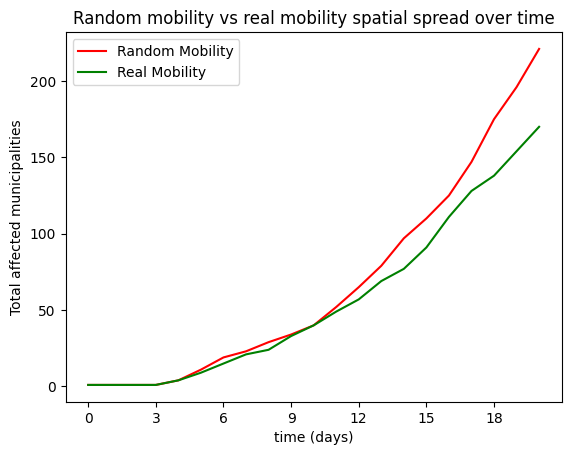

In [103]:
affect_threshold = 0.1

affected_municipalities_rnd = np.sum(merged_rnd_infections > affect_threshold, axis = 1)
affected_municipalities_ref = np.sum(merged_ref_infections > affect_threshold, axis = 1)

# Find daily max value (which is just the last value)
affected_municipalities_rnd = np.max(affected_municipalities_rnd.reshape(-1,24),axis=1)
affected_municipalities_ref = np.max(affected_municipalities_ref.reshape(-1,24),axis=1)

print(affected_municipalities_rnd)

t_days = t_max / 24

# Normal plot
x_points = np.arange(0, t_days)
plt.plot(x_points, affected_municipalities_rnd, color='r', label='Random Mobility')
plt.plot(x_points, affected_municipalities_ref, color='g', label='Real Mobility')
plt.legend()
plt.title('Random mobility vs real mobility spatial spread over time')
plt.ylabel('Total affected municipalities')
plt.xlabel('time (days)')
plt.xticks(np.arange(0, t_days, step=3))
plt.show()